# [3주차] 심화과제 - Pre-trained 모델로 효율적인 NLP 모델 학습하기

#### Q1) 어떤 task를 선택하셨나요?
- MNLI task
- MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제이다.
- BERT는 sentence pair classification에 특화되어 있어 MNLI와 같이 두 문장 간의 복잡한 의미 관계를 파악하는데 효과적이다. BERT와 비슷한 성능을 가지면서 사이즈는 작은 DistilBERT를 사용하였다.

#### Q2) 모델은 어떻게 설계하셨나요? 설계한 모델의 입력과 출력 형태가 어떻게 되나요?
- 아래 출력 포함


#### Q3) 실제로 pre-trained 모델을 fine-tuning했을 때 loss curve은 어떻게 그려지나요? 그리고 pre-train 하지 않은 Transformer를 학습했을 때와 어떤 차이가 있나요?




In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### 1. 데이터셋 준비

Kaggle 데이터셋을 다운로드 받는다.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/unlocking-language-understanding-with-the-multin/versions/2


kaggle 데이터셋은 다음과 같이 구성되어 있다.
- premise: 기준이 되는 첫 번째 문장
- hypothesis: 두 번째 문장
- label: 두 문장의 관계
  - entailment: 논리적 연결(0)
  - contradiction: 모순 관계(1)
  - neutral: 무관한 관계(2)

In [3]:
import random
import pandas as pd

def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_data = load_data(path+'/train.csv', nrows=1000)
test_data = load_data(path+'/validation_matched.csv', nrows=1000)

DistilBERT 모델용 tokenizer를 불러온다.

In [4]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


max length를 설정하기 위해 문장의 길이 분포를 확인한다.

train data의 99% 이상이 103 이하이고, test data의 99% 이상이 94 이하이다.

트랜스포머 모델은 8의 배수로 처리할 때 효율적이므로 8 X 103 = 104를 max length로 설정한다.

In [5]:
# 문장 길이 분포 확인
def analyze_length_distribution(data):
    premise_lengths = []
    hypothesis_lengths = []
    total_lengths = []

    # 각 문장을 토큰화하여 길이 계산
    for item in data:
        premise_tokens = tokenizer(item['premise'])['input_ids']
        hypothesis_tokens = tokenizer(item['hypothesis'])['input_ids']

        premise_len = len(premise_tokens)
        hypothesis_len = len(hypothesis_tokens)
        # BERT/DistilBERT는 두 문장을 [CLS] premise [SEP] hypothesis [SEP] 형태로 결합
        # 따라서 총 길이는 premise + hypothesis + 3 ([CLS]와 [SEP] 토큰)
        total_len = premise_len + hypothesis_len + 3

        premise_lengths.append(premise_len)
        hypothesis_lengths.append(hypothesis_len)
        total_lengths.append(total_len)

    print(f"=== 길이 통계 ===")
    print(f"Premise 평균 길이: {sum(premise_lengths)/len(premise_lengths):.1f}")
    print(f"Premise 최대 길이: {max(premise_lengths)}")
    print(f"Hypothesis 평균 길이: {sum(hypothesis_lengths)/len(hypothesis_lengths):.1f}")
    print(f"Hypothesis 최대 길이: {max(hypothesis_lengths)}")
    print(f"전체 시퀀스 평균 길이: {sum(total_lengths)/len(total_lengths):.1f}")
    print(f"전체 시퀀스 최대 길이: {max(total_lengths)}")

    # 90, 95, 99 퍼센타일 계산
    percentiles = [90, 95, 99]
    for p in percentiles:
        threshold = sorted(total_lengths)[int(len(total_lengths) * p/100)]
        print(f"{p}% 문장의 길이: {threshold} 이하")

print("Training Data 분석:")
analyze_length_distribution(train_data)
print("\nTest Data 분석:")
analyze_length_distribution(test_data)

Training Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 26.9
Premise 최대 길이: 189
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 49
전체 시퀀스 평균 길이: 44.1
전체 시퀀스 최대 길이: 215
90% 문장의 길이: 67 이하
95% 문장의 길이: 77 이하
99% 문장의 길이: 103 이하

Test Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 25.4
Premise 최대 길이: 138
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 46
전체 시퀀스 평균 길이: 42.5
전체 시퀀스 최대 길이: 165
90% 문장의 길이: 65 이하
95% 문장의 길이: 74 이하
99% 문장의 길이: 94 이하


In [6]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    premises, hypotheses, labels = [], [], []

    # 배치 내 각 샘플에서 premise, hypothesis, label 추출
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 함께 토큰화
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=104,
        # PyTorch 텐서로 변환하여 반환한다.
        return_tensors='pt'
    )

    # label을 텐서로 변환한다
    labels = torch.LongTensor(labels)

    # 모델 입력에 필요한 모든 정보 반환
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 16

# DataLoader 설정
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 데이터 형태 확인
for batch in train_loader:
    print("배치 크기:", batch['input_ids'].shape)
    print("어텐션 마스크 크기:", batch['attention_mask'].shape)
    print("라벨 크기:", batch['labels'].shape)
    print("\n첫 번째 배치 예시:")
    print("입력 ID:", batch['input_ids'][0])
    print("라벨:", batch['labels'][0])
    break

배치 크기: torch.Size([16, 85])
어텐션 마스크 크기: torch.Size([16, 85])
라벨 크기: torch.Size([16])

첫 번째 배치 예시:
입력 ID: tensor([  101,  2016,  2018,  2787,  2025,  2000,  3198,  2065,  2909,  2508,
         2001,  1000,  2012,  2188,  1010,  1000,  2021,  2000, 11092,  1037,
         2062,  3167,  7729,  1012,   102,  2016,  3442,  2039,  2356,  2065,
         2909,  2508,  2001,  1000,  2012,  2188,  1000,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
라벨: tensor(2)


### 2. 모델 정의

MNLI task를 위해 시퀀스 분류용 모델 DistilBertForSequenceClassification을 불러온다.

DistilBertForSequenceClassification은 기본 DistillBERT에 분류를 위한 선형 레이어가 추가되어 있다.

In [7]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3 # entailment, contradiction, neutral
)

# GPU를 사용하기 위한 옵션
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델의 입력과 출력, 예측 결과 형태를 확인한다.

In [8]:
# 예시 데이터
premise = "Conceptually cream skimming has two basic dimensions - product and geography."
hypothesis = "Product and geography are what make cream skimming work."

# 입력 형태
encoded = tokenizer(
    premise,
    hypothesis,
    padding=True,
    truncation=True,
    max_length=104,
    return_tensors='pt'
)

print("=== 입력 형태 ===")
print("input_ids 형태:", encoded['input_ids'].shape)
print("attention_mask 형태:", encoded['attention_mask'].shape)

# 모델 출력
outputs = model(**encoded)
print("\n=== 출력 형태 ===")
print("로짓 형태:", outputs.logits.shape)  # [batch_size, 3] - 3개 클래스에 대한 점수

# 예측 클래스
predicted_class = torch.argmax(outputs.logits, dim=1)
print("\n=== 예측 결과 ===")
print("예측 클래스:", predicted_class.item())  # 0: entailment, 1: contradiction, 2: neutral

# 레이블과 예측값 매핑
label_map = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
print("예측 결과:", label_map[predicted_class.item()])

=== 입력 형태 ===
input_ids 형태: torch.Size([1, 28])
attention_mask 형태: torch.Size([1, 28])

=== 출력 형태 ===
로짓 형태: torch.Size([1, 3])

=== 예측 결과 ===
예측 클래스: 2
예측 결과: neutral


### 3. Fine tuning

fine tuning 전/후를 비교하기 위해 정확도를 계산하고 모델의 성능을 평가하는 함수를 추가한다.

In [9]:
# 정확도 계산 함수
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 모델 성능 평가 및 시각화 함수
def evaluate_and_visualize(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

학습 함수를 정의한다.

In [10]:
import torch
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 학습 함수
def train_model(model, train_loader, test_loader):
    model = model.to(device)

    # transformer 미세조정에 적합한 learning rate
    lr = 2e-5
    n_epochs = 5

    # AdamW 옵티마이저 사용 (트랜스포머 모델에 더 적합)
    optimizer = AdamW(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 에폭마다 정확도 계산
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")

    return train_losses, train_accs, test_accs

fine tuning 전/후 성능을 측정한다.


=== Fine-tuning 전 모델 성능 ===
Train Accuracy: 0.3750
Test Accuracy: 0.3430

=== Fine-tuning 시작 ===


Epoch 1/5: 100%|██████████| 63/63 [02:12<00:00,  2.11s/it, loss=1.09]



Epoch 1/5
Total Loss: 68.7978
Average Loss: 1.0920
Train Accuracy: 0.4040
Test Accuracy: 0.3330



Epoch 2/5: 100%|██████████| 63/63 [02:15<00:00,  2.16s/it, loss=1.11]



Epoch 2/5
Total Loss: 68.6298
Average Loss: 1.0894
Train Accuracy: 0.3980
Test Accuracy: 0.3500



Epoch 3/5: 100%|██████████| 63/63 [02:13<00:00,  2.12s/it, loss=1.04]



Epoch 3/5
Total Loss: 68.4331
Average Loss: 1.0862
Train Accuracy: 0.4250
Test Accuracy: 0.3470



Epoch 4/5: 100%|██████████| 63/63 [02:12<00:00,  2.11s/it, loss=1.06]



Epoch 4/5
Total Loss: 68.1923
Average Loss: 1.0824
Train Accuracy: 0.4350
Test Accuracy: 0.3530



Epoch 5/5: 100%|██████████| 63/63 [02:14<00:00,  2.13s/it, loss=1.06]



Epoch 5/5
Total Loss: 68.0129
Average Loss: 1.0796
Train Accuracy: 0.4310
Test Accuracy: 0.3540


=== Fine-tuning 후 모델 성능 ===
Train Accuracy: 0.4310
Test Accuracy: 0.3540


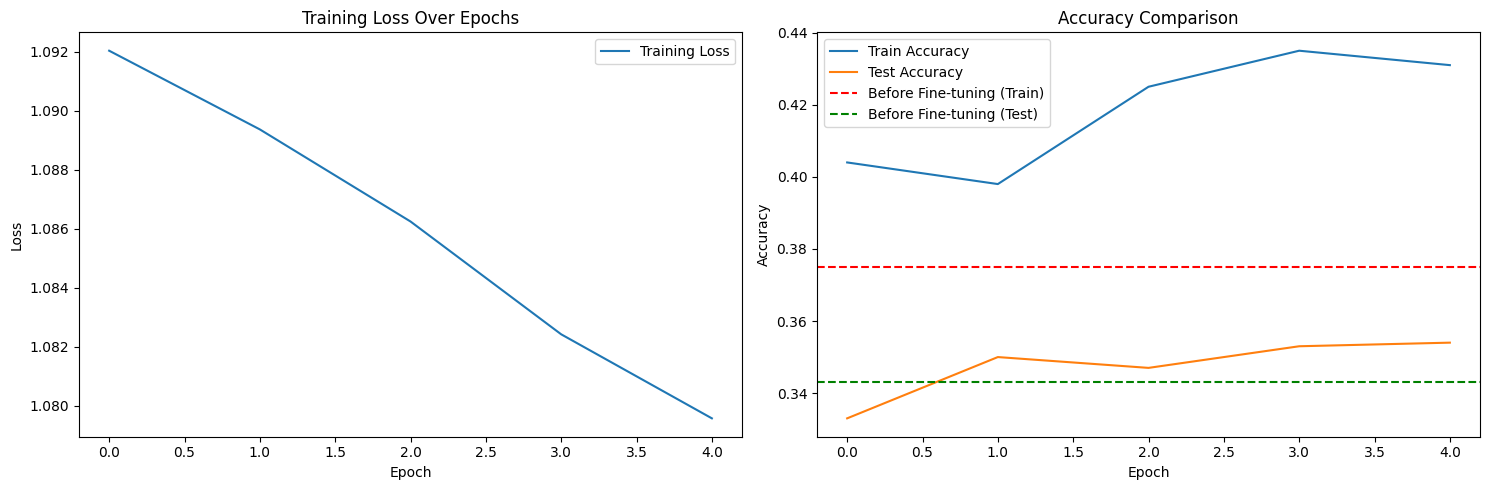


=== 성능 향상 분석 ===
Train Accuracy 향상: 5.60%
Test Accuracy 향상: 1.10%


In [11]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate_and_visualize(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")
for param in model.distilbert.parameters():
    param.requires_grad = False

train_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate_and_visualize(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")